In [13]:
from dataclasses import dataclass as dc
from fslash.core import pipe
from pampy import match as inMatch, _ as default
from ordered_set import OrderedSet as oset

from typing import Literal

In [14]:
@dc
class Tarefa:
  numero: int
  tempo_q_demora: int
  acabar_antes: int = None

  @property
  def comecar_antes(self):
    return self.acabar_antes - self.tempo_q_demora
  @comecar_antes.setter
  def comecar_antes(self, value):
    self.acabar_antes = value + self.tempo_q_demora
  def __repr__(self):
    return f"T{self.numero}({self.tempo_q_demora})"
  def __hash__(self):
    return hash(str(self))

In [15]:
@dc
class Maquina:
  numero: int
  n_tarefas_maximo: int

  def __post_init__(self):
    self.tarefas = []
  def queue(self, tarefa):
    self.tarefas.append(tarefa)
  def reset(self):
    self.tarefas = []
  @property
  def horario(self):
    horario = [] # o horario representa quando muda de tarefa para a proxima
    tempo = 0
    for tarefa in self.tarefas:
      horario.append(tempo)
      tempo += tarefa.tempo_q_demora
    return horario
  def get_tarefa_at(self, hora):
    tempo = 0
    for tarefa in self.tarefas:
      tempo += tarefa.tempo_q_demora
      if tempo > hora:
        return tarefa
    return None
  def __repr__(self):
    return f'Maquina {self.numero}: {self.tarefas}'

In [16]:
M1 = Maquina(1, 4)
M2 = Maquina(2, 3)
M3 = Maquina(3, 3)
Maquinas = [M1, M2, M3]

In [17]:
Index = int # index starts at 1
class Tarefas:
  def __init__(self, tempos: list[int], prioridades: list[Index], acabar_antes: int):
    self.tarefas = [
      Tarefa(
        numero=i+1,
        tempo_q_demora=t
      )
      for i, t in enumerate(tempos)
    ]

    self.prioridades = []
    for inds in prioridades:
      self.get(inds).acabar_antes = acabar_antes
      self.prioridades.append(self.get(inds))
    # order prioridades by tempo_q_demora
    self.prioridades.sort(key=lambda tarefa: tarefa.tempo_q_demora)
    self.makePool("number")
  def get(self,i: Index):
    return self.tarefas[i-1]
  
  def __getitem__(self, i: Index):
    return self.get(i)

  def getPrioridades(self, orederedBy: Literal["number", "tempo_q_demora"] = "number") -> list[Tarefa]:
    match orederedBy:
      case "number":
        return self.prioridades.copy()
      case "tempo_q_demora":
        return sorted(self.prioridades, key=lambda tarefa: tarefa.tempo_q_demora)
      case _:
        raise TypeError
  def getTarefas(self, orederedBy: Literal["number", "tempo_q_demora"] = "number") -> list[Tarefa]:
    match orederedBy:
      case "number":
        return self.tarefas.copy()
      case "tempo_q_demora":
        return sorted(self.tarefas, key=lambda tarefa: tarefa.tempo_q_demora)
      case _:
        raise TypeError

  def makePool(self, orederedBy: Literal["prioridades+number", "prioridades+tempo_q_demora", "number", "tempo_q_demora"] = "number") -> oset[Tarefa]:
    self.poolOrder = orederedBy
    match orederedBy:
      case "number":
        self.pool = oset(self.getTarefas("number"))
      case "tempo_q_demora":
        self.pool = oset(self.getTarefas("tempo_q_demora"))
      case "prioridades+number":
        self.pool = oset(self.getPrioridades("number")) | oset(self.getTarefas("number"))
      case "prioridades+tempo_q_demora":
        self.pool = oset(self.getPrioridades("tempo_q_demora")) | oset(self.getTarefas("tempo_q_demora"))
      case _:
        raise TypeError
    return self.pool
  
  def resetPool(self):
    return self.makePool(self.poolOrder)

  def removeFromPool(self, tarefa: Tarefa | list[Tarefa] | Index | list[Index]):
    inMatch(tarefa,
      Tarefa,       lambda tarefa:  self.pool.remove(tarefa),
      list[Tarefa], lambda tarefas: [self.pool.remove(tarefa) for tarefa in tarefas],
      Index,        lambda i:       self.pool.remove(self.get(i)),
      list[Index],  lambda inds:    [self.pool.remove(self.get(i)) for i in inds],
      default,      lambda:         exec("raise TypeError")
    )
    return self.pool
  

tarefas = Tarefas(
  tempos=[38,33,36,20,32,29,46,38,34,40],
  prioridades=[3,4,5],
  acabar_antes=24*(5-1) # 1 junho (8h) até 5 junho (8h)
)
tarefas.tarefas #TODO make tarefas str



[T1(38),
 T2(33),
 T3(36),
 T4(20),
 T5(32),
 T6(29),
 T7(46),
 T8(38),
 T9(34),
 T10(40)]

In [18]:
oset([1,2,4,4,2]) | oset([1,2,4,4,3])

OrderedSet([1, 2, 4, 3])

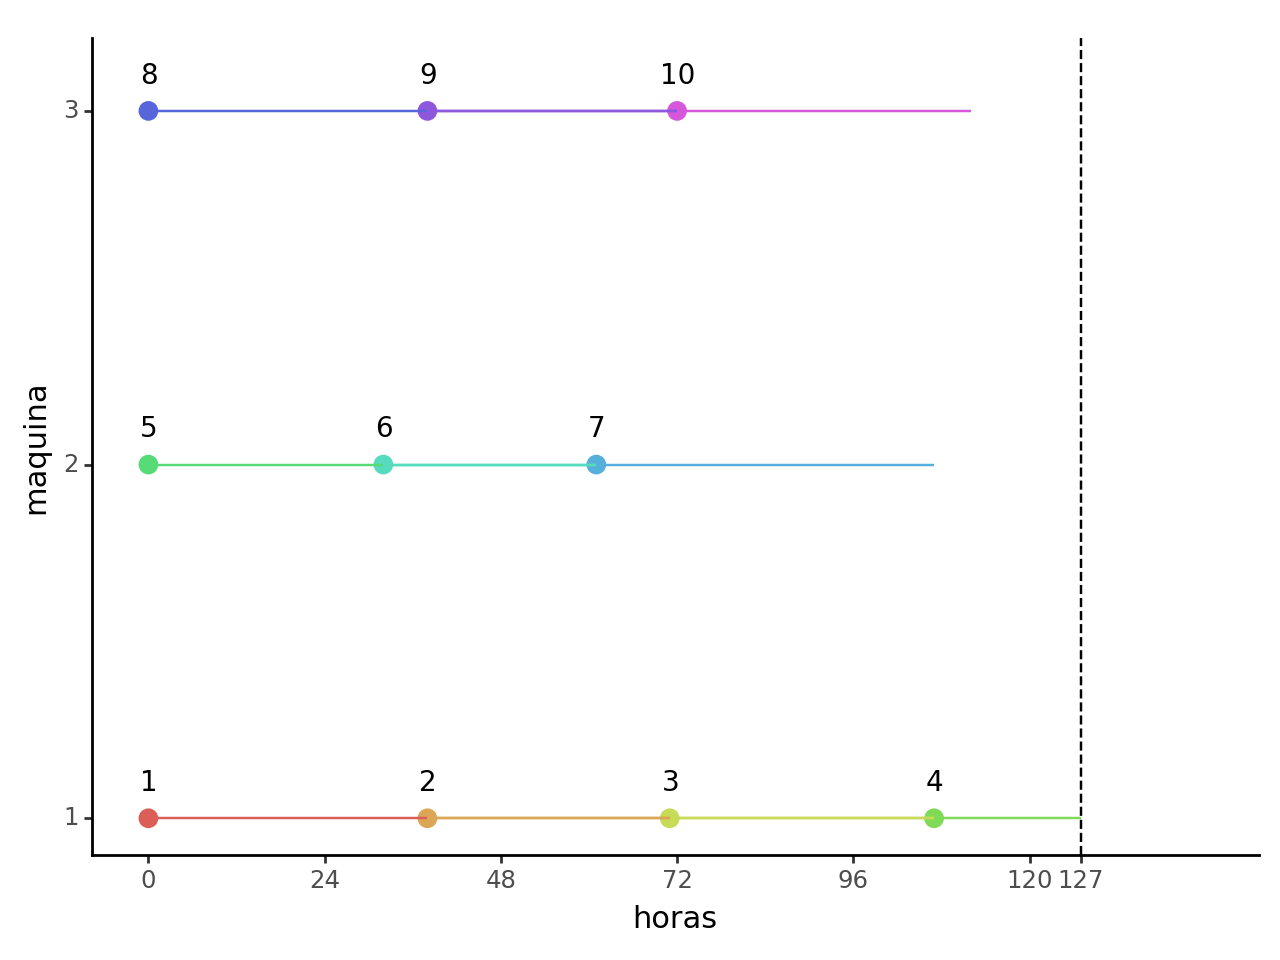

<Figure Size: (640 x 480)>

In [19]:
from plotnine import *
from pandas import DataFrame
def plot(maquinas):
  frame = DataFrame({
  'maquina': [m.numero for m in maquinas for _ in m.horario],
  'horario': [h for m in maquinas for h in m.horario],
  "horario_termina": [h + m.get_tarefa_at(h).tempo_q_demora for m in maquinas for h in m.horario],
  'tarefa': [m.get_tarefa_at(h).numero for m in maquinas for h in m.horario]
  })
  return ggplot(frame, aes(x='horario_termina', y='maquina')) + \
    geom_point(aes(x="horario", color='factor(tarefa)'), size = 3) + \
    geom_path(aes(group = "factor(maquina)", color="factor(tarefa+1)", x="horario_termina")) + \
    geom_path(aes(group = "factor(maquina)", color="factor(tarefa)", x="horario")) + \
    geom_text(aes(x = "horario", label="tarefa"), size=10, nudge_x=0.1, nudge_y=0.1) + \
    scale_color_discrete(guide=False) + \
    scale_x_continuous(breaks=[0, 24, 48, 72, 96, 120, frame.sort_values(by=['horario_termina']).iloc[-1].horario_termina]) + \
    scale_y_continuous(breaks=[1, 2, 3]) + \
    geom_vline(xintercept=frame.sort_values(by=['horario_termina']).iloc[-1].horario_termina, linetype="dashed") + \
    coord_fixed(xlim = (-0.5, 144)) + \
    labs(x="horas", y="maquina") + \
    theme_classic() + \
    theme(aspect_ratio=0.7)
# exemplo
[M.reset() for M in Maquinas]
M1.queue(tarefas[1])
M1.queue(tarefas[2])
M1.queue(tarefas[3])
M1.queue(tarefas[4])
M2.queue(tarefas[5])
M2.queue(tarefas[6])
M2.queue(tarefas[7])
M3.queue(tarefas[8])
M3.queue(tarefas[9])
M3.queue(tarefas[10])
p = plot(Maquinas)
[M.reset() for M in Maquinas]
p

In [21]:
# b) heuristica
[maquina.reset() for maquina in Maquinas]

maquinasS = sorted(Maquinas, key=lambda m: len(m.tarefas))
def permaYielder(maquinas):
  while True:
    for maquina in maquinas:
      yield maquina
pool: oset = tarefas.makePool("prioridades+tempo_q_demora")
maquinasY = permaYielder(maquinasS)

for tarefa in tarefas.getPrioridades():
  maquina = next(maquinasY)
  maquina.queue(tarefa)
  pool.remove(tarefa)

# 2º - o resto das tarefas
# reset yielder (this case is not needed cause it's only 3 but it's better to make it universal)
maquinasY = permaYielder(maquinasS)
for tarefa in pool:
  maquina = next(maquinasY)
  maquina.queue(tarefa)
maquinasS

[Maquina 1: [T4(20), T6(29), T1(38), T7(46)],
 Maquina 2: [T5(32), T2(33), T8(38)],
 Maquina 3: [T3(36), T9(34), T10(40)]]

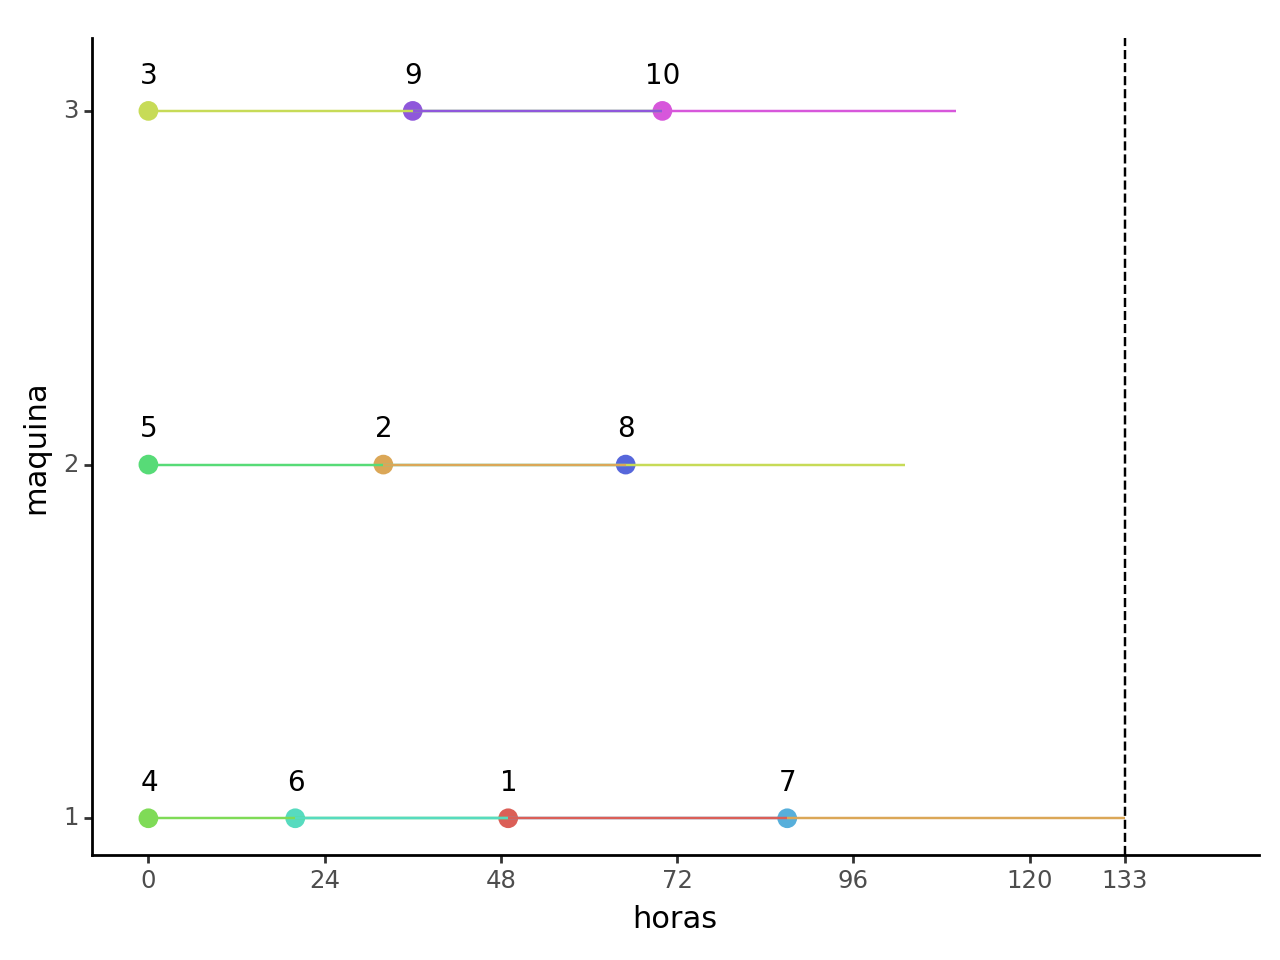

<Figure Size: (640 x 480)>

In [22]:
plot(maquinasS)